# ASVspoof5 Train-Only Probe (B -> C): Bonafide vs Spoof with Per-User Test Analysis

This notebook trains one global `B -> C` bonafide/spoof probe, then reports **per-user metrics** on the `C` test speakers.

This is the recommended first version of "per-user" analysis (global model + user-specific evaluation), instead of training a separate model per user.


In [1]:
import json
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torchaudio
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)


In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

PROJECT_ROOT = Path("/home/SpeakerRec/BioVoice")
MANIFEST_PATH = PROJECT_ROOT / "redimnet" / "tcav" / "deepfakes" / "asvspoof5" / "asvspoof5_train_only_selected_utterances_plan.csv"
SUBSET_AUDIO_ROOT = PROJECT_ROOT / "data" / "datasets" / "asvspoof5_train_only_subset_audio"

EMBED_CACHE_DIR = PROJECT_ROOT / "data" / "embeddings" / "asvspoof5_train_only_abc"
EMBED_CACHE_DIR.mkdir(parents=True, exist_ok=True)

print("DEVICE:", DEVICE)
print("MANIFEST_PATH:", MANIFEST_PATH)
print("SUBSET_AUDIO_ROOT:", SUBSET_AUDIO_ROOT)

OUT_DIR = PROJECT_ROOT / 'data' / 'models' / 'asvspoof5_train_only_probe_BC_per_user'
OUT_DIR.mkdir(parents=True, exist_ok=True)
CACHE_NPZ = EMBED_CACHE_DIR / 'embeddings_BC_global.npz'
FORCE_RECOMPUTE_EMBEDDINGS = False


DEVICE: cuda
MANIFEST_PATH: /home/SpeakerRec/BioVoice/redimnet/tcav/deepfakes/asvspoof5/asvspoof5_train_only_selected_utterances_plan.csv
SUBSET_AUDIO_ROOT: /home/SpeakerRec/BioVoice/data/datasets/asvspoof5_train_only_subset_audio


In [3]:
LABEL_MAP = {"bonafide": 0, "spoof": 1}


def build_audio_path(row, subset_root: Path) -> Path:
    # extracted subset layout: <root>/<group>/<label>/<utt_id>.flac
    return subset_root / str(row["group"]) / str(row["label"]) / f"{row['utt_id']}.flac"


def load_manifest(manifest_path: Path, subset_root: Path) -> pd.DataFrame:
    df = pd.read_csv(manifest_path)
    req = {"group", "speaker_id", "utt_id", "label", "system_id"}
    missing = req - set(df.columns)
    if missing:
        raise ValueError(f"Manifest missing columns: {sorted(missing)}")

    df = df.copy()
    df["label_str"] = df["label"].astype(str)
    df["label_id"] = df["label_str"].map(LABEL_MAP).astype(int)
    df["audio_path"] = df.apply(lambda r: str(build_audio_path(r, subset_root)), axis=1)
    df["audio_exists"] = df["audio_path"].map(lambda p: Path(p).exists())
    return df


def embed_with_redim(model, wav_path: str, device: str) -> np.ndarray:
    wav, sr = torchaudio.load(wav_path)
    if sr != 16000:
        wav = torchaudio.functional.resample(wav, sr, 16000)
    if wav.shape[0] > 1:
        wav = wav[:1, :]
    wav = wav.to(device)
    with torch.no_grad():
        emb = model(wav)
    return emb.squeeze(0).detach().cpu().numpy().astype(np.float32)


def extract_embeddings_for_df(df: pd.DataFrame, model, device: str, cache_npz: Path, force_recompute: bool = False):
    if cache_npz.exists() and not force_recompute:
        payload = np.load(cache_npz, allow_pickle=True)
        emb = payload["X"]
        utt_ids = payload["utt_ids"].astype(str)
        cache_df = pd.DataFrame({"utt_id": utt_ids, "_emb_idx": np.arange(len(utt_ids))})
        merged = df.merge(cache_df, on="utt_id", how="left", validate="one_to_one")
        if merged["_emb_idx"].isna().any():
            missing = merged.loc[merged["_emb_idx"].isna(), "utt_id"].tolist()[:10]
            raise RuntimeError(f"Cache missing utt_ids, examples: {missing}")
        X = emb[merged["_emb_idx"].astype(int).to_numpy()]
        return X

    rows = []
    vecs = []
    for rec in tqdm(df.to_dict("records"), desc=f"Embedding {len(df)} samples"):
        p = Path(rec["audio_path"])
        if not p.exists():
            raise FileNotFoundError(f"Missing audio: {p}")
        vecs.append(embed_with_redim(model, str(p), device))
        rows.append(str(rec["utt_id"]))
    X = np.stack(vecs).astype(np.float32)
    np.savez_compressed(cache_npz, X=X, utt_ids=np.array(rows, dtype=object))
    return X


def train_and_eval_logreg(X_train, y_train, X_test, y_test, class_weight="balanced"):
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)

    clf = LogisticRegression(max_iter=2000, class_weight=class_weight, random_state=42)
    clf.fit(X_train_s, y_train)

    p_train = clf.predict_proba(X_train_s)[:, 1]
    p_test = clf.predict_proba(X_test_s)[:, 1]
    yhat_train = (p_train >= 0.5).astype(int)
    yhat_test = (p_test >= 0.5).astype(int)

    metrics = {
        "train_accuracy": float(accuracy_score(y_train, yhat_train)),
        "test_accuracy": float(accuracy_score(y_test, yhat_test)),
        "train_auc": float(roc_auc_score(y_train, p_train)) if len(np.unique(y_train)) == 2 else None,
        "test_auc": float(roc_auc_score(y_test, p_test)) if len(np.unique(y_test)) == 2 else None,
        "train_confusion_matrix": confusion_matrix(y_train, yhat_train).tolist(),
        "test_confusion_matrix": confusion_matrix(y_test, yhat_test).tolist(),
        "train_classification_report": classification_report(y_train, yhat_train, output_dict=True, zero_division=0),
        "test_classification_report": classification_report(y_test, yhat_test, output_dict=True, zero_division=0),
    }
    return scaler, clf, X_train_s, X_test_s, p_train, p_test, yhat_train, yhat_test, metrics


def plot_confmat(cm, title):
    fig, ax = plt.subplots(figsize=(4,4))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(["bonafide","spoof"], rotation=30, ha="right")
    ax.set_yticklabels(["bonafide","spoof"])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(title)
    for (i,j), v in np.ndenumerate(cm):
        ax.text(j, i, str(v), ha="center", va="center")
    plt.colorbar(im, ax=ax, fraction=0.046)
    plt.tight_layout()
    return fig


In [4]:
# Load ReDimNet backbone for embedding extraction
redim_model = (
    torch.hub.load(
        "IDRnD/ReDimNet",
        "ReDimNet",
        model_name="b5",
        train_type="ptn",
        dataset="vox2",
    )
    .to(DEVICE)
    .eval()
)
print("Loaded ReDimNet on", DEVICE)


Using cache found in /home/SpeakerRec/.cache/torch/hub/IDRnD_ReDimNet_master


Loaded ReDimNet on cuda


In [5]:
manifest_df = load_manifest(MANIFEST_PATH, SUBSET_AUDIO_ROOT)
bc_df = manifest_df[manifest_df['group'].isin(['B','C'])].copy().reset_index(drop=True)
X_bc = extract_embeddings_for_df(bc_df[['utt_id','audio_path']], redim_model, DEVICE, CACHE_NPZ, force_recompute=FORCE_RECOMPUTE_EMBEDDINGS)
y_bc = bc_df['label_id'].to_numpy().astype(int)

train_mask = bc_df['group'].eq('B').to_numpy()
test_mask = bc_df['group'].eq('C').to_numpy()
X_train, y_train = X_bc[train_mask], y_bc[train_mask]
X_test, y_test = X_bc[test_mask], y_bc[test_mask]

scaler, clf, X_train_s, X_test_s, p_train, p_test, yhat_train, yhat_test, metrics = train_and_eval_logreg(X_train, y_train, X_test, y_test)
print('Global test accuracy:', metrics['test_accuracy'])


Global test accuracy: 0.821875


In [6]:
# Build predictions table for B and C, then compute per-user metrics across all users (with split column)
pred_train = bc_df.loc[train_mask, ['group','speaker_id','utt_id','label_str','label_id','system_id']].copy().reset_index(drop=True)
pred_train['split'] = 'train_B'
pred_train['prob_spoof'] = p_train
pred_train['pred_label_id'] = yhat_train
pred_train['pred_label_str'] = pred_train['pred_label_id'].map({0:'bonafide',1:'spoof'})

pred_test = bc_df.loc[test_mask, ['group','speaker_id','utt_id','label_str','label_id','system_id']].copy().reset_index(drop=True)
pred_test['split'] = 'test_C'
pred_test['prob_spoof'] = p_test
pred_test['pred_label_id'] = yhat_test
pred_test['pred_label_str'] = pred_test['pred_label_id'].map({0:'bonafide',1:'spoof'})

pred_all = pd.concat([pred_train, pred_test], ignore_index=True)
pred_all.to_csv(OUT_DIR / 'predictions_BC_all_users.csv', index=False)
pred_test.to_csv(OUT_DIR / 'test_predictions_C.csv', index=False)

rows = []
for (split, spk), g in pred_all.groupby(['split','speaker_id']):
    y_true = g['label_id'].to_numpy()
    y_hat = g['pred_label_id'].to_numpy()
    p = g['prob_spoof'].to_numpy()
    rows.append({
        'split': split,
        'group': g['group'].iloc[0],
        'speaker_id': spk,
        'n_samples': int(len(g)),
        'n_bonafide': int((y_true==0).sum()),
        'n_spoof': int((y_true==1).sum()),
        'accuracy': float(accuracy_score(y_true, y_hat)),
        'auc': float(roc_auc_score(y_true, p)) if len(np.unique(y_true)) == 2 else np.nan,
        'bonafide_recall': float(((y_hat[y_true==0]==0).mean()) if (y_true==0).any() else np.nan),
        'spoof_recall': float(((y_hat[y_true==1]==1).mean()) if (y_true==1).any() else np.nan),
    })
per_user_df = pd.DataFrame(rows).sort_values(['split','accuracy'], ascending=[True, False])
per_user_df.to_csv(OUT_DIR / 'per_user_metrics_BC.csv', index=False)
per_user_df[per_user_df['split']=='test_C'].to_csv(OUT_DIR / 'per_user_metrics_C.csv', index=False)

with open(OUT_DIR / 'scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open(OUT_DIR / 'logistic_regression.pkl', 'wb') as f:
    pickle.dump(clf, f)
(OUT_DIR / 'global_metrics.json').write_text(json.dumps(metrics, indent=2), encoding='utf-8')

print('Per-user metrics across all users (B and C):')
print(per_user_df)
print('Saved outputs ->', OUT_DIR)


Per-user metrics across all users (B and C):
      split group speaker_id  n_samples  n_bonafide  n_spoof  accuracy  \
3    test_C     C     T_2780         64          32       32  0.984375   
0    test_C     C     T_0052         64          32       32  0.937500   
4    test_C     C     T_5284         64          32       32  0.921875   
1    test_C     C     T_1783         64          32       32  0.718750   
2    test_C     C     T_2640         64          32       32  0.546875   
5   train_B     B     T_0012         64          32       32  1.000000   
6   train_B     B     T_0519         64          32       32  1.000000   
7   train_B     B     T_0854         64          32       32  1.000000   
8   train_B     B     T_0934         64          32       32  1.000000   
9   train_B     B     T_1613         64          32       32  1.000000   
10  train_B     B     T_2498         64          32       32  1.000000   
11  train_B     B     T_3688         64          32       32  1.000

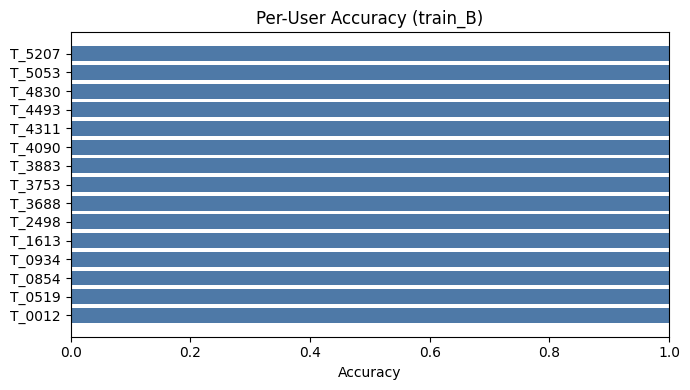

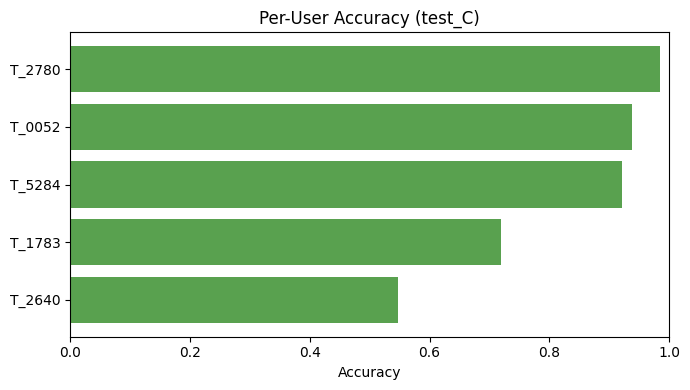

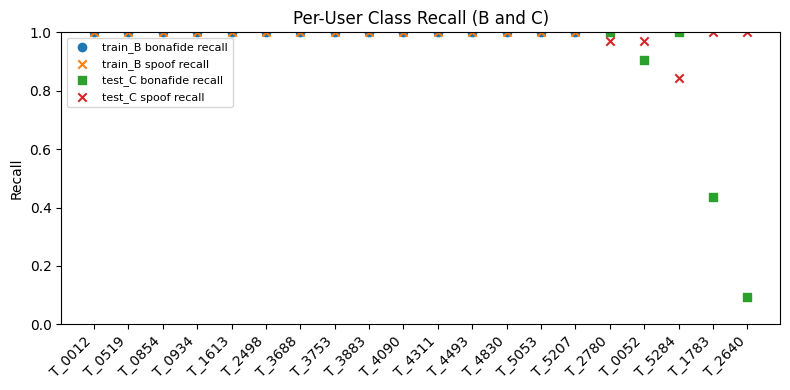

In [7]:
# Visualize per-user performance for both train users (B) and test users (C)
for split_name, color in [('train_B', '#4e79a7'), ('test_C', '#59a14f')]:
    plot_df = per_user_df[per_user_df['split'] == split_name].sort_values('accuracy')
    if plot_df.empty:
        continue
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.barh(plot_df['speaker_id'], plot_df['accuracy'], color=color)
    ax.set_xlim(0, 1)
    ax.set_xlabel('Accuracy')
    ax.set_title(f'Per-User Accuracy ({split_name})')
    plt.tight_layout(); plt.show()

fig, ax = plt.subplots(figsize=(8,4))
for split_name, marker in [('train_B','o'), ('test_C','s')]:
    g = per_user_df[per_user_df['split'] == split_name]
    if g.empty:
        continue
    ax.scatter(g['speaker_id'], g['bonafide_recall'], label=f'{split_name} bonafide recall', marker=marker)
    ax.scatter(g['speaker_id'], g['spoof_recall'], label=f'{split_name} spoof recall', marker='x')
ax.set_ylim(0,1)
ax.set_ylabel('Recall')
ax.set_title('Per-User Class Recall (B and C)')
ax.legend(fontsize=8)
plt.xticks(rotation=45, ha='right')
plt.tight_layout(); plt.show()


Speaker: T_2780


,group,speaker_id,utt_id,label_str,label_id,system_id,split,prob_spoof,pred_label_id,pred_label_str
1152,C,T_2780,T_0000013423,bonafide,0,bonafide,test_C,0.006772,0,bonafide
1153,C,T_2780,T_0000013660,bonafide,0,bonafide,test_C,0.010594,0,bonafide
1154,C,T_2780,T_0000017871,bonafide,0,bonafide,test_C,0.007152,0,bonafide
1155,C,T_2780,T_0000019778,bonafide,0,bonafide,test_C,0.001570,0,bonafide
1156,C,T_2780,T_0000021601,bonafide,0,bonafide,test_C,0.018747,0,bonafide


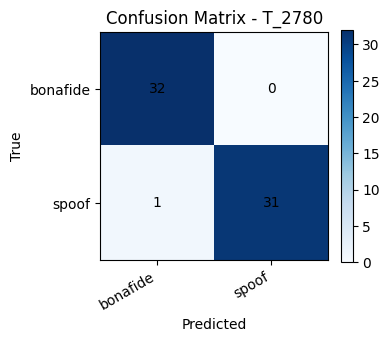

In [8]:
# Optional: inspect one test user confusion matrix
candidate = per_user_df[per_user_df['split'] == 'test_C']
speaker_to_show = candidate.iloc[0]['speaker_id'] if len(candidate) else None
if speaker_to_show is not None:
    g = pred_all[(pred_all['split'] == 'test_C') & (pred_all['speaker_id'] == speaker_to_show)]
    cm = confusion_matrix(g['label_id'], g['pred_label_id'])
    print('Speaker:', speaker_to_show)
    display(g.head())
    fig, ax = plt.subplots(figsize=(4,4))
    im = ax.imshow(cm, cmap='Blues')
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(['bonafide','spoof'], rotation=30, ha='right')
    ax.set_yticklabels(['bonafide','spoof'])
    ax.set_xlabel('Predicted'); ax.set_ylabel('True')
    ax.set_title(f'Confusion Matrix - {speaker_to_show}')
    for (i,j), v in np.ndenumerate(cm):
        ax.text(j, i, str(v), ha='center', va='center')
    plt.colorbar(im, ax=ax, fraction=0.046)
    plt.tight_layout(); plt.show()
